**Keras Tuner Example**

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


Trial 5 Complete [00h 01m 22s]
val_accuracy: 0.9490000009536743

Best val_accuracy So Far: 0.9793333411216736
Total elapsed time: 00h 06m 12s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test accuracy: 0.9764999747276306
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9942 - loss: 0.0170 - val_accuracy: 0.9796 - val_loss: 0.0793
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9969 - loss: 0.0107 - val_accuracy: 0.9787 - val_loss: 0.0815
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9977 - loss: 0.0091 - val_accuracy: 0.9785 - val_loss: 0.0851
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9975 - loss: 0.0085 - val_accuracy: 0.9782 - val_loss: 0.0951
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 0.9780 - val_loss: 0.1013
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9791 - val_loss: 0.1011
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9770 - val_loss: 0.0985
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step 

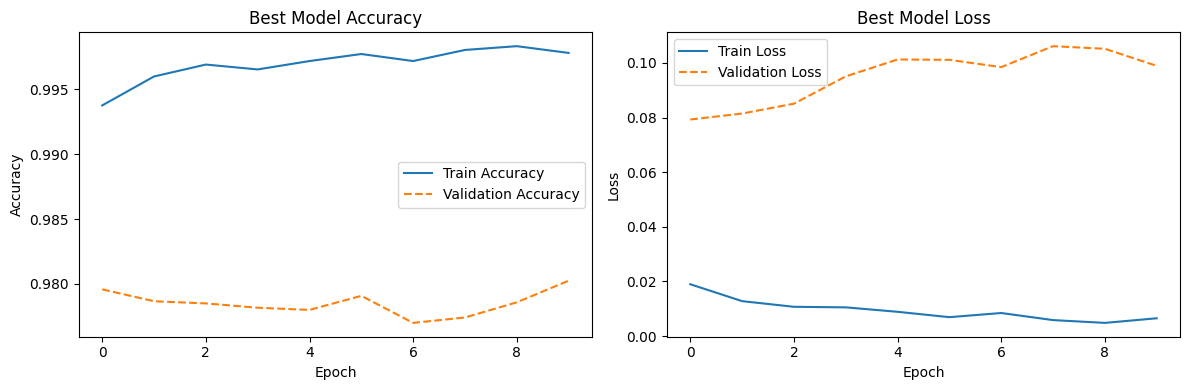

In [ ]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras_tuner import RandomSearch  # Import Keras Tuner's RandomSearch

# 1. Load the data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 2. Preprocess the data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# 3. Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# 4. Define the model-building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the number of layers and units per layer
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))

    model.add(Dense(10, activation='softmax'))

    # Tune the learning rate for the optimizer
    optimizer = keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 5. Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='mnist_tuner_dir',
    project_name='mnist_tuner'
)

# 6. Perform the hyperparameter search
tuner.search(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels)
)

# 7. Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# 8. Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, verbose=0)
print('Test accuracy:', test_accuracy)

# 9. Plot training & validation accuracy and loss values
# Since Keras Tuner does not store the history object, retrain the best model to get the history
history = best_model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels)
)

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Best Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Best Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


**Early Stoping Example**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.utils import to_categorical

# Load the data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Create validation data
val_images = train_images[50000:]
val_labels = train_labels[50000:]
train_images = train_images[:50000]
train_labels = train_labels[:50000]

# Build the model
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Number of epochs with no improvement after which training will be stopped.
    verbose=1,
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity.
)

# Train the model with early stopping
history = model.fit(train_images, train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping])

# Test the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("\nTest accuracy:", test_acc)


Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8807 - loss: 0.4104 - val_accuracy: 0.9645 - val_loss: 0.1204
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9678 - loss: 0.1095 - val_accuracy: 0.9698 - val_loss: 0.1084
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9801 - loss: 0.0678 - val_accuracy: 0.9770 - val_loss: 0.0796
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9854 - loss: 0.0475 - val_accuracy: 0.9789 - val_loss: 0.0743
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9901 - loss: 0.0321 - val_accuracy: 0.9787 - val_loss: 0.0794
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9933 - loss: 0.0241 - val_accuracy: 0.9760 - val_loss: 0.0901
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9946 - loss: 0.0191 - val_accuracy: 0.9790 - val_loss: 0.0751
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9960 - loss: 0.0138 - val_ac